In [1]:
%load_ext lab_black

In [2]:
import pickle
from pathlib import Path
from typing import Union, Dict, Optional, List
from collections import defaultdict
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from tqdm import tqdm

from camelsml.metrics import calc_nse

In [3]:
plt.style.use("../figstyle.mplstyle")

In [4]:
def load_results(folder: Union[Path, str], model_type: str, seed: int) -> Dict:
    if isinstance(folder, str):
        folder = Path(folder)
    if not folder.exists():
        raise FileNotFoundError(f"No directory found at {folder}")
    nse_values = defaultdict(dict)
    epochs = len(list(folder.rglob(f"{model_type}_seed{seed}_epoch_*.p")))
    if epochs == 0:
        raise FileNotFoundError(f"No validation runs found")
    for epoch in range(1, epochs + 1):
        file = folder / f"{model_type}_seed{seed}_epoch_{epoch}.p"
        with open(file, "rb") as results_file:
            results = pickle.load(results_file)
        for basin in results.keys():
            nse_values[f"epoch_{epoch}"][basin] = calc_nse(
                obs=results[basin]["qobs"].to_numpy(),
                sim=results[basin]["qsim"].to_numpy(),
            )
    return nse_values


def load_cv_results(
    main_folder: Union[Path, str], k, model_type: str, seed: int, epoch: int = 30
) -> Dict:
    if isinstance(main_folder, str):
        main_folder = Path(main_folder)
    if not main_folder.exists():
        raise FileNotFoundError(f"No directory found at {main_folder}")
    results = {}
    full_results = defaultdict(dict)
    for i in tqdm(range(k)):
        folder = main_folder / str(i)
        folder = list(folder.glob("*"))
        if len(folder) != 1:
            warnings.warn(f"Check your file structure in {i}")
        folder = folder[0]
        results[i] = load_results(folder, model_type, seed)
        for key in list(results[i].keys())[:epoch]:
            for basin in results[i][key].keys():
                full_results[key][basin] = results[i][key][basin]
    return full_results

In [5]:
def parse_results(
    folder: Union[str, Path], k: int = 5, skip: Optional[Union[int, List[int]]] = None
) -> Dict:
    if isinstance(skip, int):
        skip = [skip]
    folder = Path(folder)
    results = {}
    for i in range(k):
        if not skip is None and i in skip:
            continue
        file = folder / f"{i}" / "i_list.pickle"
        with open(file, "rb") as infile:
            results[i] = pickle.load(infile)
    return results


def calc_i(
    permutations: List,
    nse_values: Dict,
    epoch: int = 30,
    k: int = 5,
    min_nse=0,
    skip: Optional[Union[int, List[int]]] = None,
) -> pd.DataFrame:
    if isinstance(skip, int):
        skip = [skip]
    features = list(
        permutations[list(permutations.keys())[0]].keys()
    )  # permutations.keys()[0]])
    nse_values = nse_values[f"epoch_{epoch}"]
    means = defaultdict(lambda: defaultdict(lambda: 0))
    index = -1
    for i in range(k):
        if not skip is None and i in skip:
            print(f"skipped {i}!")
            index += 1
            continue
        else:
            index += 1
        fold = permutations[index]
        # features = list(fold.keys())
        for feature in features:
            feature_results = fold[feature]
            for k_ in list(feature_results.keys()):
                # print(k_, len(list(feature_results.keys())))
                for basin in feature_results[k_].keys():
                    means[feature][basin] += feature_results[k_][basin] / len(
                        list(feature_results.keys())
                    )

    for feature in features:
        for basin in means[feature].keys():
            if nse_values[basin] >= min_nse:
                means[feature][basin] = nse_values[basin] - means[feature][basin]
            else:
                means[feature][basin] = np.nan
    return pd.DataFrame.from_dict(means).dropna()

In [6]:
def boxplot_feature_importance(
    importances: pd.DataFrame, features: List[str], ax: Optional[plt.Axes] = None
):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    ax.boxplot(importances[features].values)
    ax.set_xticklabels(
        [feature.replace("_", "\_") for feature in features], rotation=45
    )
    # ax.set_yscale("log")
    ax.grid("on")

In [7]:
k = 5
permutations = parse_results(
    "/home/bernhard/git/Master-Thesis/runs/correlation_reduction/all_features_cv/permutation/",
    k=k,
)
nse_values = load_cv_results(
    main_folder="/home/bernhard/git/Master-Thesis/runs/correlation_reduction/all_features_cv/",
    model_type="ealstm",
    seed="19970204",
    k=k,
)
importance_all_features = calc_i(permutations, nse_values, k=k, min_nse=0.5, epoch=20)

100%|██████████| 5/5 [00:17<00:00,  3.40s/it]


In [8]:
def importance_metrics(importances: pd.DataFrame) -> pd.DataFrame:
    fracs = defaultdict(dict)
    for feature in importances.columns:
        # fracs[feature][f"Amount i > {limit}"] = (importances[feature] > limit).sum()
        # fracs[feature][f"Fraction i > {limit}"] = fracs[feature][
        #    f"Amount i > {limit}"
        # ] / len(importances[feature])
        # fracs[feature][f"Max"] = importances[feature].max()
        # fracs[feature][
        #    "|i|"
        # ] = f"{importances[feature].mean():.4f}+-{importances[feature].std():.2f}"
        fracs[feature]["95%"] = np.percentile(importances[feature], q=95)
        fracs[feature]["75%"] = np.percentile(importances[feature], q=75)
        fracs[feature]["Median"] = np.median(importances[feature])
        fracs[feature]["25%"] = np.percentile(importances[feature], q=25)
        fracs[feature]["5%"] = np.percentile(importances[feature], q=5)
    # df = pd.DataFrame.from_dict(fracs).T.sort_values(
    #    f"Fraction i > {limit}", ascending=False
    # )
    df = pd.DataFrame.from_dict(fracs).T.sort_values("Median", ascending=False)
    return df


fracs_all_features = importance_metrics(importance_all_features)
folder = Path("../doc/thesis/tables/results_section")
folder.mkdir(parents=True, exist_ok=True)
fracs_all_features.drop(fracs_all_features.index[20:]).to_latex(
    folder / "overfit_importance.tex", float_format="%.2f"
)
fracs_all_features.drop(fracs_all_features.index[20:])

,95%,75%,Median,25%,5%
Q95,9.965331,0.423366,0.122163,0.039146,-0.012220
baseflow_index_ceh,1.223817,0.213468,0.079608,0.021573,-0.008008
p_mean,0.329857,0.112807,0.042575,0.007947,-0.017017
aridity,0.104584,0.036468,0.013234,0.000704,-0.021357
Q5,0.609510,0.059715,0.009635,0.000348,-0.027473
p_seasonality,0.118962,0.016138,0.003102,-0.000706,-0.021852
area,0.113298,0.014959,0.002624,-0.000407,-0.012037
inwater_perc,0.119842,0.015252,0.002568,-0.001016,-0.020580
elev_10,0.100327,0.015951,0.002489,-0.001558,-0.022612
low_prec_dur,0.061404,0.010816,0.002300,-0.001176,-0.020019


In [9]:
def plot_importances(
    importances: pd.DataFrame,
    feature: str,
    ax: Optional[plt.Axes] = None,
    color: str = "blue",
    label: Optional[str] = None,
):
    x = importances[feature][importances[feature] <= 1]
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    ax.hist(x, facecolor=color, bins=100, density=True, label=label)


"""
fig, axes = plt.subplots(2, 2, sharex=True, sharey=False, figsize=[4.7747, 4.7747])
axes = axes.flatten()

features = ["Q95", "baseflow_index_ceh", "porosity_hypres_5", "num_reservoir"]

save_path = Path("../doc/thesis/figures/permutation/all_features_cv")
save_path.mkdir(exist_ok=True, parents=True)

for i, feature in enumerate(features):
    plot_importances(importance_all_features, feature, ax=axes[i])
    print(
        feature.replace("_", "\\_"),
        feature.replace("_", "\\_").encode(encoding="UTF-8"),
    )
    axes[i].set_title(feature.replace("_", "\_"))
    axes[i].grid()
fig.tight_layout()
matplotlib.use("pgf")
matplotlib.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
    }
)
fig.savefig(save_path / "histogram_all.pgf")
fig.savefig(save_path / "histogram_all.pdf")
# plt.show()
"""

'\nfig, axes = plt.subplots(2, 2, sharex=True, sharey=False, figsize=[4.7747, 4.7747])\naxes = axes.flatten()\n\nfeatures = ["Q95", "baseflow_index_ceh", "porosity_hypres_5", "num_reservoir"]\n\nsave_path = Path("../doc/thesis/figures/permutation/all_features_cv")\nsave_path.mkdir(exist_ok=True, parents=True)\n\nfor i, feature in enumerate(features):\n    plot_importances(importance_all_features, feature, ax=axes[i])\n    print(\n        feature.replace("_", "\\_"),\n        feature.replace("_", "\\_").encode(encoding="UTF-8"),\n    )\n    axes[i].set_title(feature.replace("_", "\\_"))\n    axes[i].grid()\nfig.tight_layout()\nmatplotlib.use("pgf")\nmatplotlib.rcParams.update(\n    {\n        "pgf.texsystem": "pdflatex",\n        "font.family": "serif",\n        "text.usetex": True,\n        "pgf.rcfonts": False,\n    }\n)\nfig.savefig(save_path / "histogram_all.pgf")\nfig.savefig(save_path / "histogram_all.pdf")\n# plt.show()\n'

## The above results seem to imply that the EA-LSTM model likes extra precipitation info.
Possibly because the timeseries do not contain enough information? Or maybe sequence_length should be increased?

## The results below indicate that not many basins care about the "physical" features
This is model dependent, will do the same analysis of the reduced model to see if this is still the case

In [10]:
chosen_features = np.genfromtxt(
    "../runs/correlation_reduction/chosen_features/use_features.txt", dtype="str"
)
# BUG!!
chosen_features = chosen_features[
    np.logical_and(chosen_features != "dpsbar", chosen_features != "dom_land_cover")
]
fracs_all_features.loc[chosen_features, :].sort_values(
    "Amount i > 0.1", ascending=False
)

KeyError: 'Amount i > 0.1'

In [ ]:
"""fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
axes = axes.flatten()

features = ["area", "elev_10", "elev_50", "urban_perc"]

for i, feature in enumerate(features):
    plot_importances(importance_all_features, feature, ax=axes[i])
    axes[i].set_title(feature.replace("_", "\_"))
    axes[i].grid()
# fig.tight_layout()
plt.show()"""

## Importance of reduced, physically based system.

In [11]:
k = 5
permutations_chosen_features = parse_results(
    "/home/bernhard/git/Master-Thesis/runs/correlation_reduction/chosen_features_cv/permutation/",
    k=k,
)
nse_values_chosen_features = load_cv_results(
    main_folder="/home/bernhard/git/Master-Thesis/runs/correlation_reduction/chosen_features_cv/",
    model_type="ealstm",
    seed="19970204",
    k=k,
    epoch=13,
)
importance_chosen_features = calc_i(
    permutations_chosen_features, nse_values_chosen_features, k=k, min_nse=0.5, epoch=13
)

100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


In [15]:
fracs_chosen_features = importance_metrics(importance_chosen_features)
fracs_chosen_features

,95%,75%,Median,25%,5%
no_gw_perc,0.220276,0.060053,0.014390,-0.005388,-0.044958
area,0.195242,0.045833,0.010997,-0.002933,-0.033202
crop_perc,0.237749,0.036921,0.007739,-0.006077,-0.038760
grass_perc,0.156469,0.038096,0.007703,-0.006286,-0.040757
frac_low_perc,0.188428,0.040833,0.007666,-0.007347,-0.050271
inwater_perc,0.337713,0.047324,0.007595,-0.004841,-0.045574
dwood_perc,0.156545,0.039021,0.007538,-0.005772,-0.041314
urban_perc,0.257442,0.040473,0.007389,-0.004802,-0.039405
elev_90,0.156776,0.032869,0.006966,-0.005595,-0.043087
frac_high_perc,0.357755,0.041122,0.005946,-0.004497,-0.034893


In [ ]:
"""fig, axes = plt.subplots(
    2, 2, sharex=True, sharey=False, figsize=[10, 10]
)  # , figsize=[4.7747, 4.7747])
axes = axes.flatten()

features = ["inwater_perc", "no_gw_perc", "area", "nsig_low_perc"]

for i, feature in enumerate(features):
    plot_importances(
        importance_chosen_features, feature, ax=axes[i], color="blue", label="Chosen"
    )
    plot_importances(
        importance_all_features, features, ax=axes[i], color="red", label="All"
    )
    axes[i].legend()
    axes[i].set_title(feature.replace("_", "\_"))
    axes[i].grid()
fig.tight_layout()
plt.show()"""

## Importance of fixed all feature run

In [16]:
k = 5
permutations_all_features_fixed = parse_results(
    "/home/bernhard/git/Master-Thesis/runs/correlation_reduction/all_features_fixed_cv/permutation/",
    k=k,
)
nse_values_all_features_fixed = load_cv_results(
    main_folder="/home/bernhard/git/Master-Thesis/runs/correlation_reduction/all_features_fixed_cv/",
    model_type="ealstm",
    seed="19970204",
    k=k,
    epoch=20,
)
importance_all_features_fixed = calc_i(
    permutations_all_features_fixed,
    nse_values_all_features_fixed,
    k=k,
    min_nse=0.7,
    epoch=20,
)

100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


In [17]:
fracs_all_features_fixed = importance_metrics(importance_all_features_fixed)
fracs_all_features_fixed

,95%,75%,Median,25%,5%
area,0.141997,2.485323e-02,5.023046e-03,-1.425941e-04,-0.018393
p_mean,0.099263,2.146996e-02,5.020332e-03,-1.691595e-03,-0.024468
no_gw_perc,0.089452,2.150555e-02,4.650092e-03,-3.060589e-03,-0.042253
aridity,0.062317,1.744747e-02,3.649242e-03,-2.392458e-03,-0.023827
low_prec_dur,0.097494,1.990374e-02,3.628684e-03,-1.294875e-03,-0.023721
tawc,0.117024,2.111640e-02,3.616301e-03,-2.746859e-03,-0.026476
grass_perc,0.106031,2.146851e-02,3.591462e-03,-3.653164e-03,-0.027138
crop_perc,0.098236,2.126386e-02,3.412597e-03,-1.134019e-03,-0.026636
low_prec_freq,0.057914,1.332895e-02,3.303269e-03,-2.271655e-03,-0.018482
root_depth,0.132860,2.434752e-02,3.192564e-03,-3.715293e-03,-0.040243


In [ ]:
"""fig, axes = plt.subplots(
    2, 2, sharex=True, sharey=False, figsize=[10, 10]
)  # , figsize=[4.7747, 4.7747])
axes = axes.flatten()

features = ["inwater_perc", "frac_high_perc", "clay_perc", "low_nsig_perc"]

for i, feature in enumerate(features):
    plot_importances(
        importance_chosen_features, feature, ax=axes[i], color="blue", label="Chosen"
    )
    plot_importances(
        importance_all_features_fixed, features, ax=axes[i], color="red", label="All"
    )
    axes[i].legend()
    axes[i].set_title(feature.replace("_", "\_"))
    axes[i].grid()
    axes[i].set_yscale("log")
fig.tight_layout()
plt.show()"""

## Importance CAMELS-US vs CAMELS-GB
### CAMELS-US:

There is a bug in the permutation test code that caused the test to skip root_depth in camels-us...

In [18]:
k = 5
permutations_common_features_us = parse_results(
    "/home/bernhard/git/Master-Thesis/runs/camels_us/chosen_features_cv_us/permutation/",
    k=k,
)
nse_values_common_features_us = load_cv_results(
    main_folder="/home/bernhard/git/Master-Thesis/runs/camels_us/chosen_features_cv_us/",
    model_type="ealstm",
    seed="19970204",
    k=k,
    epoch=20,
)
importance_common_features_us = calc_i(
    permutations_common_features_us,
    nse_values_common_features_us,
    k=k,
    min_nse=0.7,
    epoch=20,
)

100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


In [19]:
fracs_common_features_us = importance_metrics(importance_common_features_us)
fracs_common_features_us

,95%,75%,Median,25%,5%
clay_frac,0.241644,0.106540,0.035069,0.012249,-0.019663
elev_mean,1.017810,0.153083,0.031903,0.005362,-0.006426
sand_frac,0.247481,0.062980,0.023619,0.003531,-0.021064
silt_frac,0.183796,0.061538,0.016900,0.002443,-0.032660
area_gages2,0.252304,0.079419,0.016815,0.002731,-0.009572
soil_conductivity,0.230185,0.052016,0.009856,0.000087,-0.020034
soil_depth_pelletier,0.225693,0.042307,0.004627,-0.000141,-0.010117
water_frac,0.021391,0.000000,0.000000,0.000000,-0.000368
organic_frac,0.119495,0.000000,0.000000,0.000000,0.000000


### CAMELS-GB:

In [20]:
k = 5
permutations_common_features_gb = parse_results(
    "/home/bernhard/git/Master-Thesis/runs/camels_us/chosen_features_cv_gb/permutation/",
    k=k,
)
nse_values_common_features_gb = load_cv_results(
    main_folder="/home/bernhard/git/Master-Thesis/runs/camels_us/chosen_features_cv_gb/",
    model_type="ealstm",
    seed="19970204",
    k=k,
    epoch=20,
)
importance_common_features_gb = calc_i(
    permutations_common_features_gb,
    nse_values_common_features_gb,
    k=k,
    min_nse=0.7,
    epoch=20,
)

100%|██████████| 5/5 [00:11<00:00,  2.35s/it]


In [22]:
fracs_common_features_gb = importance_metrics(importance_common_features_gb)
fracs_common_features_gb

,95%,75%,Median,25%,5%
root_depth,0.455664,0.109919,0.041306,0.006003,-0.021361
organic_perc,0.367679,0.044904,0.010901,-0.000328,-0.021714
elev_50,0.315216,0.042812,0.010521,-0.000474,-0.017623
clay_perc,0.406009,0.069316,0.008610,0.000109,-0.018061
area,0.191097,0.045136,0.008113,0.000158,-0.014990
conductivity_cosby,0.655941,0.046603,0.007731,-0.000079,-0.014021
silt_perc,0.208210,0.028976,0.004303,-0.002765,-0.034704
sand_perc,0.101597,0.013097,0.002018,-0.001494,-0.025099
inwater_perc,0.256152,0.023399,0.001747,-0.001891,-0.023566
soil_depth_pelletier,0.100735,0.011250,0.000555,-0.000737,-0.016759


In [23]:
"""fig, axes = plt.subplots(
    5, 2, sharex=True, sharey=False, figsize=[10, 30]
)  # , figsize=[4.7747, 4.7747])
axes = axes.flatten()

features = {
    "root_depth": "missing",
    "clay_perc": "clay_frac",
    "conductivity_cosby": "soil_conductivity",
    "elev_50": "elev_mean",
    "organic_perc": "organic_frac",
    "inwater_perc": "water_frac",
    "area": "area_gages2",
    "silt_perc": "silt_frac",
    "sand_perc": "sand_frac",
    "soil_depth_pelletier": "soil_depth_pelletier",
}

for i, feature in enumerate(features.keys()):
    plot_importances(
        importance_common_features_gb, feature, ax=axes[i], color="blue", label="GB"
    )
    axes[i].set_title(
        f"{feature} (GB), missing in US because of NaN".replace("_", "\_")
    )
    try:
        plot_importances(
            importance_common_features_us,
            features[feature],
            ax=axes[i],
            color="red",
            label="US",
        )
        axes[i].set_title(
            f"{feature} (GB), {features[feature]} (US)".replace("_", "\_")
        )
    except KeyError:
        print(f"Skipped {feature} in CAMELS-US")
    axes[i].legend()

    axes[i].grid()
    # axes[i].set_yscale("log")
fig.tight_layout()
plt.show()
"""

'fig, axes = plt.subplots(\n    5, 2, sharex=True, sharey=False, figsize=[10, 30]\n)  # , figsize=[4.7747, 4.7747])\naxes = axes.flatten()\n\nfeatures = {\n    "root_depth": "missing",\n    "clay_perc": "clay_frac",\n    "conductivity_cosby": "soil_conductivity",\n    "elev_50": "elev_mean",\n    "organic_perc": "organic_frac",\n    "inwater_perc": "water_frac",\n    "area": "area_gages2",\n    "silt_perc": "silt_frac",\n    "sand_perc": "sand_frac",\n    "soil_depth_pelletier": "soil_depth_pelletier",\n}\n\nfor i, feature in enumerate(features.keys()):\n    plot_importances(\n        importance_common_features_gb, feature, ax=axes[i], color="blue", label="GB"\n    )\n    axes[i].set_title(\n        f"{feature} (GB), missing in US because of NaN".replace("_", "\\_")\n    )\n    try:\n        plot_importances(\n            importance_common_features_us,\n            features[feature],\n            ax=axes[i],\n            color="red",\n            label="US",\n        )\n        axes[i]

### Kratzert third paper features

In [24]:
k = 5
permutations_kratzert_features_us = parse_results(
    "/home/bernhard/git/Master-Thesis/runs/camels_us/kratzert_features_cv_us/permutation/",
    k=k,
)

nse_values_kratzert_features_us = load_cv_results(
    main_folder="/home/bernhard/git/Master-Thesis/runs/camels_us/kratzert_features_cv_us/",
    model_type="lstm",
    seed="19970204",
    k=k,
    epoch=13,
)
importance_kratzert_features_us = calc_i(
    permutations_kratzert_features_us,
    nse_values_kratzert_features_us,
    k=k,
    min_nse=0.5,
    epoch=13,
)

100%|██████████| 5/5 [00:10<00:00,  2.06s/it]


In [25]:
fracs_kratzert_features_us = importance_metrics(importance_kratzert_features_us)
fracs_kratzert_features_us.to_latex(
    folder / "kratzert_features_importance.tex", float_format="%.2f"
)
fracs_kratzert_features_us

,95%,75%,Median,25%,5%
area_gages2,0.416675,0.093201,2.271585e-02,3.562782e-04,-0.020863
frac_snow,0.263607,0.064919,2.029591e-02,1.088403e-03,-0.016137
aridity,0.333895,0.095058,1.846802e-02,2.692202e-03,-0.026896
elev_mean,0.250295,0.058236,1.608950e-02,4.016265e-04,-0.020589
gvf_diff,0.131033,0.043780,1.311760e-02,-4.515524e-04,-0.035311
low_prec_freq,0.147238,0.037909,1.235349e-02,-2.015793e-03,-0.027549
geol_permeability,0.124241,0.036023,1.175795e-02,-2.893537e-03,-0.045959
slope_mean,0.193931,0.043104,1.079230e-02,-3.406910e-04,-0.031069
clay_frac,0.168554,0.054324,1.065967e-02,-2.661151e-04,-0.040753
high_prec_freq,0.151721,0.038230,1.053907e-02,-1.618782e-03,-0.025549


(-0.1, 1.0)

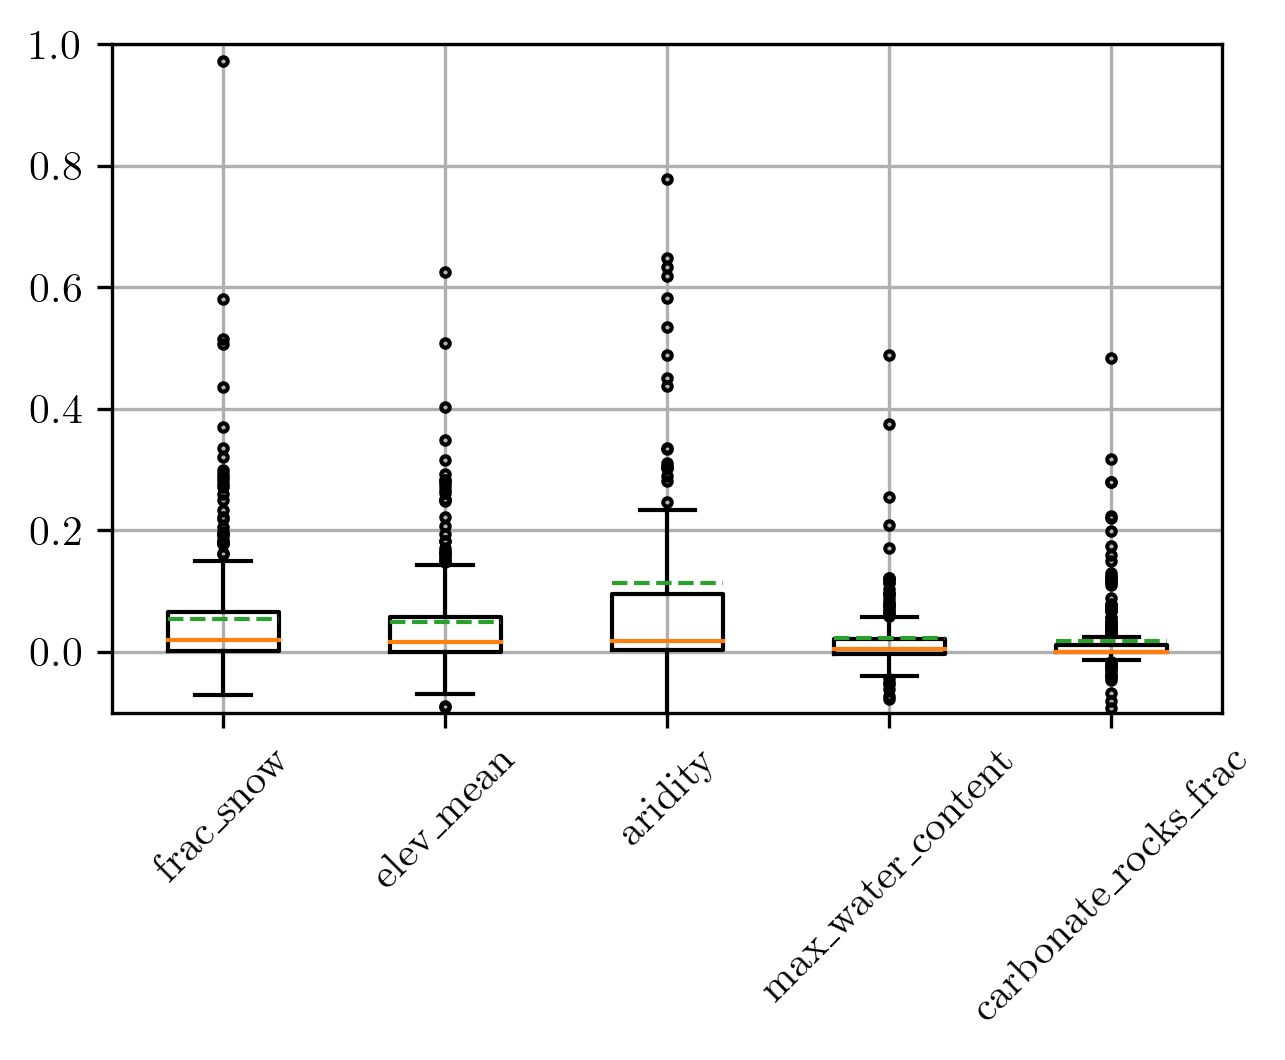

In [26]:
fig, ax = plt.subplots(1, 1)
boxplot_feature_importance(
    importances=importance_kratzert_features_us,
    features=[
        "frac_snow",
        "elev_mean",
        "aridity",
        "max_water_content",
        "carbonate_rocks_frac",
    ],
    ax=ax,
)
ax.set_ylim([-0.1, 1])

fracs_kratzert_features_us = importance_metrics(
    importance_kratzert_features_us, limit=0.1
)
fracs_kratzert_features_us

## Notes on feature importances
Kratzert et al did not run a static feature importance analysis on the third paper (the one with testing on ungauged basins). On the second paper when he ran a feature importance analysis he observed that mean precipitation was the most important feature. To me this could in theory imply that the gauged basin model uses the mean precipitation as a simple way to "recognize" each basin (this possibility Felix mentioned earlier too). My results here indicate that the snow fraction is more important than in Kratzert's analysis. What these results do agree with however is that hydrological information is more important than land coverage and soil attributes. A bit dissapointing for physical understanding, perhaps? Could always train a new model without these hydrological features to see how that performs, though!

Also, the fact that static information about precipitation like high_prec_frec is still deemed important to me implies that there is potential for improving our LSTM model in the future. All that information should be able to be taken from the time series, implying to me that the LSTM has potential to learn more time dependencies than it does now. 

## Combined dataset. Some notes.

* Times series are differnent. Only 3 in common. (I use 6 right now for CAMELS-GB, Kratzert uses 5 for CAMELS-US)
    - This I already knew though, and it would be interesting to look at a reduced set of itme series anyway.
* Land coverage information is structured differently. 
    - CAMELS-US only has fractions for the dominant land cover for each basin. CAMELS-GB has much more information here as it contains fractions from several land covers.
* There are some attributes I think could be comparable to each other. 
    - |CAMELS-US | CAMELS-GB |
      |-------------------|-----------------|
      |sand_frac|sand_perc|
      |silt_frac|silt_perc|
      |clay_frac|clay_perc|
      |organic_frac|organic_perc|
      |max_water_content|tawc (unsure)|
      |root_depth_XX|root_depth (Both are available as percentiles)|
      |soil_depth_pelletier|soil_depth_pelletier|
      |soil_conductivity|conductivity_(hypres or cosby?)|
      |soil_porosity|soil_porosity_(hypres or cosby?)|
      |||



Camels US: Dominating land cover [string],   CAMELS GB: all land covers
           coverage fraction of dominating,  coverage fraction of several types
           
This leads to:

1: The model gets the fraction of dominating, but no context for it.

2: Same as above, but also include land cover type as input (this input is non-numerical)

In [27]:
k = 5
permutations_mixed = parse_results(
    "/home/bernhard/git/Master-Thesis/runs/combined_dataset/mixed/permutation/",
    k=k,
)
nse_values_mixed = load_cv_results(
    main_folder="/home/bernhard/git/Master-Thesis/runs/combined_dataset/mixed/",
    model_type="ealstm",
    seed="19970204",
    k=k,
    epoch=30,
)

100%|██████████| 5/5 [00:27<00:00,  5.43s/it]


In [28]:
def calc_i_transfer(
    permutations: List,
    nse_values: Dict,
    epoch: int = 30,
    k: int = 5,
    min_nse=0,
    skip: Optional[Union[int, List[int]]] = None,
) -> pd.DataFrame:
    if isinstance(skip, int):
        skip = [skip]
    if isinstance(skip, list):
        dividor = k - len(skip)
    else:
        dividor = k
    nse_values = nse_values[f"epoch_{epoch}"]
    means = defaultdict(lambda: defaultdict(lambda: 0))
    index = -1
    for i in range(k):
        if not skip is None and i in skip:
            print(f"skipped {i}!")
            continue
        else:
            index += 1
        fold = permutations[index]
        features = list(fold.keys())
        for feature in features:
            feature_results = fold[feature]
            for k_ in list(feature_results.keys()):
                for basin in feature_results[k_].keys():
                    feature_results[k_][basin]
                    means[feature][basin] += feature_results[k_][basin] / (
                        len(list(feature_results.keys())) * dividor
                    )
        for feature in features:
            for basin in means[feature].keys():
                if nse_values[basin] >= min_nse:
                    means[feature][basin] = nse_values[basin] - means[feature][basin]
                else:
                    means[feature][basin] = np.nan

    return pd.DataFrame.from_dict(means).dropna()

In [29]:
importance_mixed = calc_i(
    permutations_mixed,
    nse_values_mixed,
    k=k,
    min_nse=0,
    epoch=30,
)
importance_mixed

,soil_depth_pelletier,frac_forest,gvf_max,p_mean,pet_mean,p_seasonality,frac_snow,aridity,high_prec_freq,high_prec_dur,low_prec_freq,low_prec_dur,area,porosity_cosby,conductivity_cosby,sand_perc,silt_perc,clay_perc,organic_perc
us_03384450,-0.065453,-0.124773,-0.008705,-0.033772,-0.069978,0.080332,-0.003517,-0.006118,0.027214,0.023943,-0.027862,-0.023031,-0.006413,0.099469,0.081045,0.058340,-0.111860,0.021372,0.013368
us_06892000,-0.088484,-0.010156,0.061519,-0.001992,0.021000,-0.024836,0.001143,-0.011935,-0.002169,-0.001844,-0.005013,-0.007314,0.110619,-0.092086,-0.077034,-0.066582,-0.047468,-0.052174,0.003449
us_06339100,-0.108248,-0.028963,-0.104473,-0.044658,0.107660,-0.164783,-0.037428,-0.053009,0.094962,-0.147914,-0.034720,-0.061450,0.077659,-0.036661,-0.124660,-0.056629,-0.116548,-0.084229,-0.002092
us_13235000,0.005051,0.066466,0.104612,-0.018885,0.108324,0.021700,0.443532,-0.021941,0.064430,0.352212,0.196408,0.161332,0.374944,0.038658,0.044802,-0.028069,0.105144,0.155117,0.030141
us_07335700,0.000436,0.029285,0.036900,0.021213,0.071977,-0.006312,0.069302,0.000708,0.028029,0.013095,-0.003063,0.005161,0.141007,0.023141,0.001362,0.002658,0.014375,-0.002542,0.000046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gb_36006,0.000293,0.052813,0.060368,0.019709,-0.012560,0.023254,0.065625,0.206511,0.067102,0.017919,0.123584,0.008905,0.245547,0.005294,-0.029508,-0.036551,0.092526,0.138912,-0.010778
gb_81007,0.015063,0.006818,0.166115,-0.001058,0.003143,0.010905,0.008857,0.032296,0.057733,0.044130,0.026585,0.000453,0.013744,0.002827,0.019493,0.008985,0.041607,0.001319,0.001928
gb_13005,0.057680,0.178244,0.081974,0.239865,0.042387,0.552978,-0.007385,0.188738,0.179245,0.067731,1.386911,0.126964,0.091545,0.049713,0.054948,0.093181,0.115304,0.067359,0.004786
gb_27026,0.003597,-0.019465,0.194628,0.101849,0.047543,0.089977,-0.010595,0.202189,0.000391,-0.049242,0.227979,-0.003771,0.040445,0.015781,-0.033871,0.263193,0.090135,0.024140,0.093046


In [31]:
fracs_mixed = importance_metrics(importance_mixed)
fracs_mixed

,95%,75%,Median,25%,5%
aridity,0.654534,0.203155,0.060041,0.007605,-0.061542
pet_mean,1.170563,0.168690,0.058988,0.010466,-0.043420
p_seasonality,0.694284,0.159326,0.053036,0.005274,-0.078044
high_prec_freq,0.631738,0.159442,0.048350,0.003910,-0.072286
area,0.373808,0.103118,0.037628,0.002928,-0.085168
gvf_max,0.486946,0.118366,0.036873,0.006115,-0.068218
frac_forest,0.555227,0.114261,0.036323,0.004904,-0.062763
conductivity_cosby,0.668536,0.134991,0.031749,-0.000284,-0.072382
low_prec_freq,0.658715,0.130280,0.030755,-0.001114,-0.101828
clay_perc,0.335655,0.076818,0.024511,-0.001379,-0.104763


In [32]:
def split_importances(importance_mixed: pd.DataFrame) -> pd.DataFrame:
    importance_us = importance_mixed[importance_mixed.index.str.contains("us")]
    importance_gb = importance_mixed[importance_mixed.index.str.contains("gb")]
    return importance_us, importance_gb

In [33]:
importance_mixed_us, importance_mixed_gb = split_importances(importance_mixed)

In [35]:
fracs_mixed_us = importance_metrics(importance_mixed_us)
fracs_mixed_us

,95%,75%,Median,25%,5%
pet_mean,0.411146,0.127152,0.049031,0.006200,-0.072063
p_seasonality,0.318422,0.114066,0.039043,0.003803,-0.068959
frac_forest,0.305464,0.108669,0.037922,0.006284,-0.070044
area,0.374047,0.096142,0.030610,0.000505,-0.084465
high_prec_freq,0.452940,0.093455,0.027358,-0.001738,-0.073572
gvf_max,0.275706,0.073082,0.026205,0.002685,-0.060080
frac_snow,0.593238,0.102789,0.025086,0.000004,-0.045118
clay_perc,0.251371,0.070935,0.021154,-0.001970,-0.088774
aridity,0.546848,0.074410,0.020926,-0.002881,-0.055413
low_prec_dur,0.369979,0.075083,0.018491,-0.001963,-0.060461


In [37]:
fracs_mixed_gb = importance_metrics(importance_mixed_gb)
fracs_mixed_gb

,95%,75%,Median,25%,5%
aridity,0.717420,0.264131,0.133713,0.039442,-0.059495
high_prec_freq,1.034346,0.209049,0.076049,0.013081,-0.069035
low_prec_freq,1.117823,0.207151,0.070207,0.008949,-0.107155
p_seasonality,0.968867,0.208560,0.069597,0.007600,-0.083009
pet_mean,1.745954,0.225910,0.067409,0.014620,-0.017680
conductivity_cosby,0.961782,0.232864,0.052635,0.005401,-0.071165
gvf_max,0.652075,0.155791,0.050287,0.010727,-0.077662
area,0.355300,0.112596,0.042991,0.005390,-0.087063
frac_forest,0.798935,0.126333,0.033896,0.003745,-0.056698
sand_perc,0.513961,0.106940,0.032207,0.003234,-0.102685


In [38]:
k = 5
permutations_train_us_val_gb_no_organic_no_gvf = parse_results(
    "/home/bernhard/git/Master-Thesis/runs/combined_dataset/train_us_val_gb_no_organic_no_gvf/permutation/",
    k=k,
)

nse_values_train_us_val_gb_no_organic_no_gvf = defaultdict(lambda: defaultdict(int))

for i in tqdm(range(k)):  # (range(1, 3)):  # Remember to fix
    results_ = load_results(
        folder=f"/home/bernhard/git/Master-Thesis/runs/combined_dataset/train_us_val_gb_no_organic_no_gvf/val_gb/{i}",
        model_type="ealstm",
        seed="19970204",
    )
    for epoch in results_:
        for basin in results_[epoch]:
            nse_values_train_us_val_gb_no_organic_no_gvf[epoch][basin] += (
                results_[epoch][basin] / k
            )

100%|██████████| 5/5 [01:29<00:00, 17.89s/it]


In [39]:
importance_train_us_val_gb_no_organic_no_gvf = calc_i_transfer(
    permutations_train_us_val_gb_no_organic_no_gvf,
    nse_values_train_us_val_gb_no_organic_no_gvf,
    k=k,
    min_nse=0.5,
    epoch=14,
)
importance_train_us_val_gb_no_organic_no_gvf

,soil_depth_pelletier,frac_forest,p_mean,pet_mean,p_seasonality,frac_snow,aridity,high_prec_freq,high_prec_dur,low_prec_freq,low_prec_dur,area,porosity_cosby,conductivity_cosby,sand_perc,silt_perc,clay_perc
gb_54004,0.505909,0.666350,0.511115,0.509933,0.476580,0.520436,0.602364,0.519785,0.498102,0.507217,0.484076,0.574225,0.517005,0.506390,0.509814,0.612279,0.646430
gb_56002,0.473659,0.467761,0.509466,0.441430,0.484527,0.472457,0.448224,0.468510,0.460193,0.445678,0.480618,0.489643,0.480723,0.476545,0.461337,0.461594,0.462316
gb_78004,0.566202,0.572736,0.555682,0.560113,0.559279,0.555913,0.556727,0.558045,0.562269,0.567529,0.561080,0.555105,0.564619,0.564330,0.562733,0.561208,0.561944
gb_4005,0.585459,0.582513,0.577916,0.592211,0.583544,0.585035,0.581350,0.577080,0.589129,0.679007,0.617882,0.592331,0.586542,0.580916,0.584566,0.586810,0.579452
gb_84014,0.562665,0.561076,0.560211,0.572480,0.562339,0.575779,0.562700,0.557969,0.556915,0.564503,0.553763,0.560458,0.566575,0.566044,0.566023,0.561281,0.559022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gb_72015,0.570862,0.570718,0.570026,0.572788,0.572241,0.574481,0.583883,0.572856,0.579372,0.575732,0.571051,0.581749,0.573417,0.573884,0.573278,0.573917,0.571734
gb_27084,0.480297,0.482392,0.487743,0.485076,0.477932,0.479023,0.478258,0.490947,0.486334,0.470466,0.471871,0.490874,0.486063,0.482475,0.480807,0.481089,0.469058
gb_84030,0.528856,0.538657,0.544119,0.543950,0.548897,0.538211,0.559221,0.544570,0.542226,0.541064,0.533482,0.573297,0.541924,0.540809,0.546302,0.539897,0.534104
gb_80005,0.464655,0.452337,0.422116,0.457054,0.453237,0.453631,0.454644,0.457235,0.439521,0.473106,0.463116,0.457545,0.453975,0.457213,0.454248,0.455379,0.460007


In [41]:
fracs_train_us_val_gb_no_organic_no_gvf = importance_metrics(
    importance_train_us_val_gb_no_organic_no_gvf
)
fracs_train_us_val_gb_no_organic_no_gvf

,95%,75%,Median,25%,5%
aridity,0.642865,0.583102,0.526568,0.456771,0.410959
low_prec_freq,0.681030,0.598921,0.523912,0.474301,0.418506
high_prec_freq,0.617552,0.574351,0.523149,0.457165,0.410882
area,0.625829,0.574775,0.520780,0.453422,0.403937
pet_mean,0.626179,0.576438,0.517607,0.457944,0.422651
frac_snow,0.619424,0.575130,0.517143,0.446286,0.410632
porosity_cosby,0.623395,0.574110,0.517005,0.463002,0.406503
silt_perc,0.621581,0.576728,0.516513,0.459022,0.412588
p_mean,0.624896,0.571273,0.515764,0.465855,0.411136
frac_forest,0.631787,0.580013,0.515661,0.459768,0.408122


In [42]:
k = 5
permutations_all_features_concat_seq_len_gb = parse_results(
    "/home/bernhard/git/Master-Thesis/runs/correlation_reduction/all_features_concat_seq_len_cv/permutation/",
    k=k,
)


nse_values_common_features_gb = load_cv_results(
    main_folder="/home/bernhard/git/Master-Thesis/runs/correlation_reduction/all_features_concat_seq_len_cv/",
    model_type="lstm",
    seed="19970204",
    k=k,
    epoch=15,
)

100%|██████████| 5/5 [00:11<00:00,  2.29s/it]


In [43]:
importance_all_features_concat_seq_len_cv = calc_i(
    permutations_all_features_concat_seq_len_gb,
    nse_values_common_features_gb,
    k=k,
    min_nse=0.5,
    epoch=15,
)
importance_all_features_concat_seq_len_cv

,num_reservoir,reservoir_cap,dwood_perc,ewood_perc,grass_perc,shrub_perc,crop_perc,urban_perc,inwater_perc,bares_perc,...,clay_perc,organic_perc,bulkdens,tawc,porosity_cosby,porosity_hypres,conductivity_cosby,conductivity_hypres,root_depth,soil_depth_pelletier
56012,-0.002157,0.000000,0.029004,-0.022900,-0.002889,-0.002721,0.008372,-0.003764,-0.002254,0.000192,...,0.000090,-0.003102,0.014420,0.032728,-0.006100,-0.004046,0.000117,-0.001431,2.502548e-02,0.002810
54004,-0.006968,0.000000,-0.031391,-0.002719,-0.004548,0.000170,-0.027574,0.124019,0.004782,-0.000002,...,-0.004288,-0.006821,0.021818,0.034974,-0.000628,-0.003759,-0.005649,0.028062,-4.693973e-03,0.000485
28015,0.507943,-0.034447,1.005530,-0.043567,-0.185901,0.005234,-0.063649,-0.037938,-0.002964,0.177591,...,-0.189248,0.000017,-0.034548,-0.072697,0.035495,-0.163038,0.125436,0.161182,-2.719473e-02,-0.182587
36009,0.000000,0.000000,0.014944,0.000023,0.010836,-0.000385,-0.014307,0.011727,0.006416,-0.000815,...,0.146432,-0.000039,-0.016108,0.029788,0.061281,0.002601,0.174488,0.095206,1.368750e-02,0.044701
56002,-0.000063,0.000000,0.000871,0.002879,0.013546,0.001790,0.041187,-0.011116,-0.009302,0.002642,...,-0.008376,0.000205,-0.000738,0.003611,-0.000347,0.000845,0.011782,-0.007717,-5.446264e-07,0.002636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36006,0.000000,-0.040541,0.045305,-0.051644,-0.009351,0.072648,0.188552,0.002576,-0.077018,0.000318,...,-0.084258,0.015179,-0.008782,-0.031258,-0.007634,-0.029752,0.031593,-0.073025,3.908386e-01,0.000276
81007,0.000000,-0.000088,-0.004070,0.011084,-0.009241,0.002795,0.023520,-0.004570,0.019491,-0.000147,...,-0.006576,-0.008450,0.007444,0.022663,0.001931,0.011625,-0.008226,0.014870,1.208087e-03,0.068932
13005,0.000000,0.000000,0.002760,-0.002864,-0.009245,-0.006643,-0.028883,0.001935,-0.021709,0.031057,...,0.003506,-0.001038,0.022780,0.001159,0.013767,-0.003235,-0.012998,0.036208,3.003752e-02,0.113715
27026,0.000000,0.004225,0.032776,0.007082,0.000396,-0.000320,0.021105,0.057191,0.001340,-0.006044,...,-0.003839,-0.000038,0.003474,-0.015523,-0.003855,-0.008235,0.001350,0.036535,1.845480e-01,0.018963


In [44]:
fracs_all_features_concat_seq_len_cv = importance_metrics(
    importance_all_features_concat_seq_len_cv
)
folder = Path("../doc/thesis/tables/results_section")
folder.mkdir(parents=True, exist_ok=True)
fracs_all_features_concat_seq_len_cv.drop(
    fracs_all_features_concat_seq_len_cv.index[20:]
).to_latex(folder / "all_features_concat_seq_len_importance.tex", float_format="%.2f")

(-0.1, 0.2)

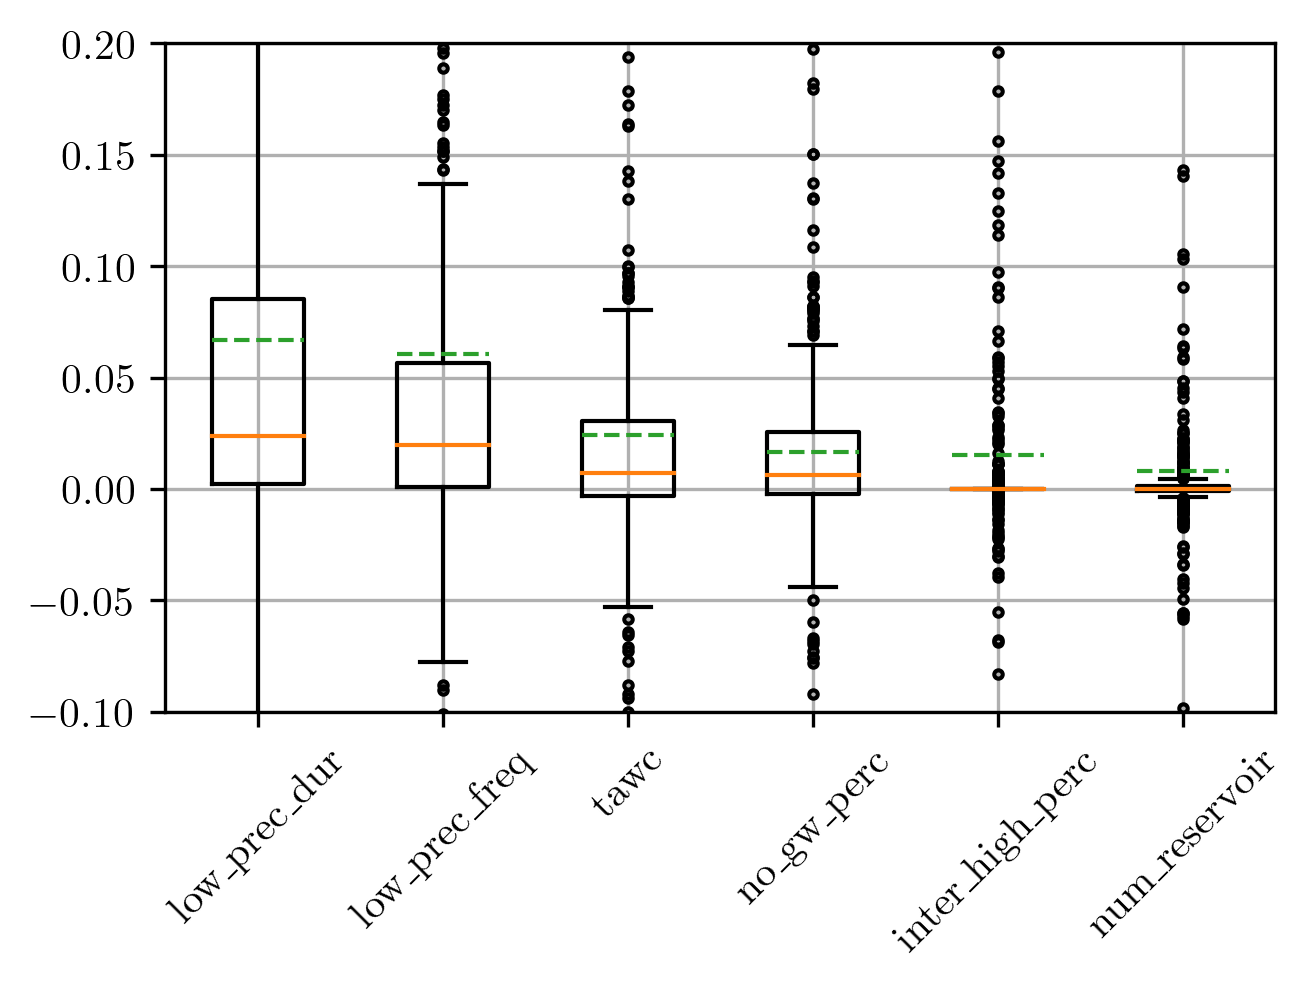

In [45]:
fig, ax = plt.subplots(1, 1)
boxplot_feature_importance(
    importances=importance_all_features_concat_seq_len_cv,
    features=[
        "low_prec_dur",
        "low_prec_freq",
        "tawc",
        "no_gw_perc",
        "inter_high_perc",
        "num_reservoir",
    ],
    ax=ax,
)
ax.set_ylim([-0.1, 0.2])

In [46]:
k = 5
permutations_mixed_concat = parse_results(
    "/home/bernhard/git/Master-Thesis/runs/combined_dataset/mixed_concat/permutation/",
    k=k,
)


nse_values_mixed_concat = load_cv_results(
    main_folder="/home/bernhard/git/Master-Thesis/runs/combined_dataset/mixed_concat",
    model_type="lstm",
    seed="19970204",
    k=k,
    epoch=15,
)

100%|██████████| 5/5 [00:27<00:00,  5.41s/it]


In [47]:
importance_mixed_concat = calc_i(
    permutations_mixed_concat,
    nse_values_mixed_concat,
    k=k,
    min_nse=0.5,
    epoch=15,
)
importance_mixed_concat

,soil_depth_pelletier,frac_forest,gvf_max,p_mean,pet_mean,p_seasonality,frac_snow,aridity,high_prec_freq,high_prec_dur,low_prec_freq,low_prec_dur,area,porosity_cosby,conductivity_cosby,sand_perc,silt_perc,clay_perc,organic_perc
us_03384450,-0.015549,-0.111616,0.098867,0.036281,0.032349,0.005589,0.039042,0.025453,0.011637,0.029757,0.030582,-0.007853,0.019431,-0.007312,0.002939,0.024945,0.028374,0.033424,8.781934e-02
us_06892000,-0.079495,0.032283,-0.007231,-0.000883,0.103831,-0.045043,0.003380,-0.063219,-0.100805,-0.184736,0.024987,-0.126761,0.296745,-0.071136,-0.037782,-0.054791,-0.117054,-0.067571,-7.730558e-03
us_13235000,0.001602,-0.117854,0.121563,-0.057214,0.022910,-0.095717,0.401218,0.034225,-0.004076,0.042967,-0.052322,-0.043787,0.165629,-0.035016,0.026167,-0.007299,0.167070,0.072672,1.134748e-02
us_07335700,0.001171,-0.000260,0.050365,0.022517,0.027794,0.001180,0.000277,0.002303,0.084029,0.013550,0.136205,0.026889,0.208489,0.048342,0.011639,0.016778,-0.002366,0.001929,6.215504e-04
us_11482500,0.000205,0.027749,0.000215,0.029033,0.071565,0.032236,-0.000908,-0.001512,0.010763,0.015457,0.004899,0.011686,0.000382,-0.006958,-0.003002,0.001412,0.018766,-0.002457,7.457015e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gb_36006,-0.004536,0.073006,0.198829,0.062015,-0.000831,0.230574,0.191412,0.192585,0.145342,0.367707,0.630838,0.061864,0.227641,0.008281,0.185553,0.025014,0.047852,0.132982,5.777933e-03
gb_81007,0.095156,-0.004799,0.137675,0.001765,-0.000082,-0.000244,-0.001985,0.006261,0.041009,0.030338,0.046668,0.019991,-0.005820,0.001249,-0.007733,0.002944,-0.006973,-0.015388,1.233856e-01
gb_13005,0.303663,0.155563,0.001384,0.026173,-0.000022,0.011422,0.085351,0.041424,0.038427,0.052731,24.172458,0.005702,0.183486,0.016332,0.011225,-0.007963,0.067339,0.078608,5.284509e-02
gb_27026,-0.007761,-0.016729,0.036514,0.011366,0.105583,0.216036,0.134515,0.405521,-0.050855,0.010958,0.437276,0.272250,0.065866,0.049153,-0.067043,0.316365,0.046587,0.016687,5.697499e-03


In [48]:
def importance_metrics_mixed(importances: pd.DataFrame) -> pd.DataFrame:
    gb = importances.loc[importances.index.str.contains("gb_")]
    us = importances.loc[importances.index.str.contains("us_")]
    us = importance_metrics(importances=us)
    gb = importance_metrics(importances=gb)
    mixed = (
        pd.concat({"GB": gb, "US": us}, axis=1)
        .swaplevel(0, 1, axis=1)
        .sort_index(axis=1)
    )
    mixed = mixed[["95%", "75%", "Median", "25%", "5%"]]
    return mixed

In [49]:
fracs_mixed_concat = importance_metrics_mixed(importance_mixed_concat)
folder = Path("../doc/thesis/tables/results_section")
folder.mkdir(parents=True, exist_ok=True)
fracs_mixed_concat.to_latex(
    folder / "mixed_concat_importance.tex",
    float_format="%.2f",
    multicolumn_format="c",
)
fracs_mixed_concat

95%                 75%              Median  \
                            GB        US        GB        US        GB   
aridity               0.663479  0.350233  0.220261  0.062129  0.057979   
high_prec_freq        0.434579  0.222040  0.138869  0.072457  0.043837   
low_prec_freq         0.731447  0.140097  0.144263  0.049227  0.041155   
p_seasonality         0.502789  0.333935  0.151611  0.083075  0.034596   
area                  0.375956  0.392371  0.095434  0.098314  0.026937   
gvf_max               0.482645  0.216914  0.110405  0.061640  0.025502   
pet_mean              0.835571  0.298044  0.121865  0.126536  0.021576   
clay_perc             0.346200  0.182028  0.094788  0.068661  0.020738   
silt_perc             0.421200  0.265539  0.075079  0.070720  0.016461   
p_mean                0.362883  0.194598  0.062269  0.037803  0.013991   
frac_forest           0.414967  0.361565  0.077276  0.115759  0.013934   
sand_perc             0.312628  0.206387  0.067155  0.056380  0.013620   
high_prec_dur         0.314617  0.188398  0.061521  0.052811  0.012734   
porosity_cosby        0.222175  0.152612  0.057304  0.043520  0.011283   
low_prec_dur          1.276957  0.267036  0.061707  0.041229  0.010251   
conductivity_cosby    0.547133  0.114233  0.087754  0.025038  0.008869   
organic_perc          0.210422  0.102967  0.044700  0.011295  0.004582   
frac_snow             0.318375  0.409538  0.056137  0.095871  0.002929   
soil_depth_pelletier  0.281880  0.247835  0.021530  0.032357  0.000811   

                                     25%                  5%            
                            US        GB        US        GB        US  
aridity               0.012774  0.009494 -0.000582 -0.035932 -0.050729  
high_prec_freq        0.022474  0.004664 -0.001262 -0.050960 -0.058155  
low_prec_freq         0.013768  0.005003 -0.001073 -0.042545 -0.053439  
p_seasonality         0.023521  0.003229 -0.001687 -0.043039 -0.046854  
area                  0.016470  0.000070 -0.002995 -0.043222 -0.062479  
gvf_max               0.018066  0.000650 -0.001902 -0.039249 -0.037770  
pet_mean              0.054932  0.000335  0.006263 -0.017177 -0.057689  
clay_perc             0.021631 -0.000765 -0.000269 -0.068897 -0.049423  
silt_perc             0.014168 -0.001752 -0.006412 -0.057886 -0.068176  
p_mean                0.009226 -0.001981 -0.001507 -0.066893 -0.046427  
frac_forest           0.035453 -0.000874  0.002340 -0.036079 -0.041644  
sand_perc             0.013924 -0.003483 -0.004904 -0.056603 -0.059220  
high_prec_dur         0.014297  0.000087 -0.000483 -0.039622 -0.039353  
porosity_cosby        0.009763 -0.003398 -0.003080 -0.069685 -0.053225  
low_prec_dur          0.008746 -0.001435 -0.004106 -0.041641 -0.037214  
conductivity_cosby    0.003122 -0.002277 -0.003317 -0.046159 -0.052705  
organic_perc          0.000758 -0.006558 -0.000280 -0.057953 -0.018363  
frac_snow             0.023107 -0.000919  0.000719 -0.025553 -0.029695  
soil_depth_pelletier  0.001559 -0.002152 -0.001254 -0.051931 -0.024301